In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# Validation of `pycachesim` and Layer-Conditions Predictions

Predictions are compared to measurements on a wide selection of different architectures: Intel Ivy Bridge (`ivyep1`), Intel Skylake X (`skylakesp2`), AMD Zen (`naples1`), AMD Zen2 (`rome1`), Cavium ThunderX2 (`warmup`) and Fujitsu A64FX (`qpace4`). Measurements are performed with `build_and_run.py` and results gained with performance counters using `likwid-perfctr` and performance metrics defined in Kerncraf's [example machine files](https://github.com/RRZE-HPC/kerncraft/blob/master/examples/machine-files/).

Predictions are produced by `simulate.py` with the help of `kerncraft.cacheprediction`. Two methods are used independent of one another: `pycachesim` (CS) and Layer-Conditions (LC). In some situations LCs are not applicable and were therefore omitted.

Validation is performed on a varity of kernels. All kernels operate on 8-byte elements (i.e. of type `double`). See `kernels/*.c` for implementation details. For each kernel parmeter studies are performed, varying the dimensions of the underlying datastructures. The kernels grouped in three categories:
* 1D kernels (`update`, `copy`, `load`, `store`, `1d-3pt`), depend on a single parameter: the length of the underlying vectors.
* 2D kernels (`2d-5pt`, `matvec`, `transmatvec`), depend on a two parameter: the dimensions of the matrix/field. operated on.
* 3D kernels (`3d-7pt`, `3d-r3-11pt`), depend on a three parameter: the dimensions of the matrix/field operated on. The outer dimension is chosen such that the data will not fit into the largest cache.

In [2]:
# boilerplate includes
from glob import glob
import itertools
import math
import os
import warnings

import numpy as np
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import pandas as pd
    import matplotlib as mpl
    import matplotlib.pyplot as plt

In [3]:
# Load all pregenerated information, measurements and predictions
if os.path.exists("results/"):
    data = {}
    for data_file in itertools.chain(glob("results/*.pkl.gz"), glob("results/predicted/*.pkl.gz")):
        d = pd.read_pickle(data_file)
        for i in range(len(d.dimensions.iloc[0])):
            d[f'dimension_{i}'] = d.dimensions.map(lambda d: int(d[i]))
        data[data_file] = d

    df = pd.concat(data.values(), ignore_index=True)
    df.to_pickle("validataion-results.pkl.gz")
else:
    try:
        df = pd.read_pickle("validataion-results.pkl.gz")
    except:
        print("Place validataion-results.pkl.gz into the validation folder or generate data yourself.")
        raise

## Study of 1D-Kernels
The 1D kernels have the following properties:
 * `update`: `a[i] += 0.0001;`, one store and one load per iteration.
 * `copy`: `a[i] = b[i];`, one store, one load and another load –from write-allocate– per iteration.
 * `load`: `s += a[i];`, one load per iteration.
 * `store`: `a[i] = 23.42;`, one store and one load –from write-allocate– per iteratioon.
 * `1d-3pt`: `a[x] = b[x-1] + b[x] + b[x+1];`, one store, three loads and another load –from write-allocate– per iteration.

In [4]:
def plotlinear(hostname, columns):
    # very detailed 1D kernel analysis, produces a lot of information and is therefore ignored for now
    kernels = ['update', 'copy', 'load', 'store', '1d-3pt']

    fig, ax = plt.subplots(figsize=(15,1+3*len(columns)))
    ax.set_title(hostname)
    pltdata = []
    yticklabels = []
    for k in kernels:
        d = df.query("kernel == @k and hostname == @hostname").sort_values(['dimension_0'])
        if d.empty: continue
        for c in columns:
            for s in ['measured', 'pycachesim', 'layer-conditions']:
                rowdata = d.query("source == @s")[c].values.transpose()
                if len(rowdata):
                    pltdata.append(rowdata)
                elif pltdata:
                    pltdata.append(np.array([float('nan')]*len(pltdata[-1])))
                else:
                    continue
                if s == 'pycachesim':
                    yticklabels.append(f"{k} {c}       CS")
                else:
                    yticklabels.append({'measured':"meas.", 'pycachesim': 'CS', 'layer-conditions': 'LC'}[s])
            if pltdata:
                pltdata.append([float('nan')]*len(pltdata[-1]))
                yticklabels.append("")
    if not pltdata:
        return
    im = ax.imshow(np.array(pltdata, dtype='float64'), aspect='auto', interpolation='nearest', vmin=0, vmax=3.5)
    ax.set_yticks(range(len(pltdata)))
    ax.set_yticklabels(yticklabels)
    ax.set_xticks(range(0, len(d.dimension_0.unique()), 4))
    ax.set_xticklabels(sorted(d.dimension_0.unique())[::4], rotation=90);
    ax.set_xlabel("# of 8-byte elements per array")
    ax.grid(axis='x')
    fig.colorbar(im)

The following plots show the number of cache lines transfered color coded, in relation to the array lengths (in elements on x-axis). Each architecture has a different selection of columns shown, this is because their capabilitie of measurements differ and unmeasurable matrics (e.g., evicts on AMD architectures) were left out. Each measurement is accompanied by the corresponding pycachesim simulation (CS) and Layer Condition (LC) predictions.

`ivyep` shows almost perfect match between predictions, with both models, and measurements. The transition zones are sometimes off, where softer transitions are measured and hard transitions are predicted.

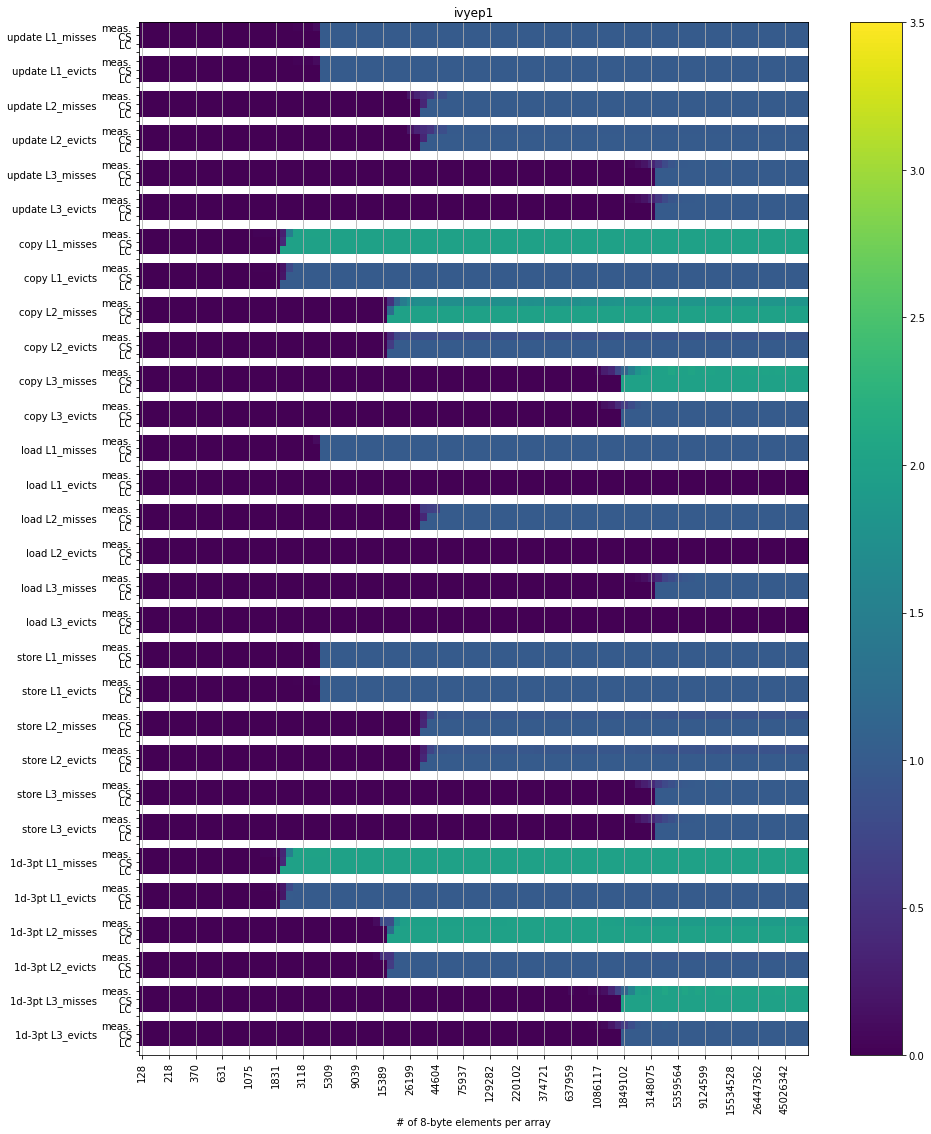

In [5]:
plotlinear('ivyep1', ['L1_misses', 'L1_evicts', 'L2_misses', 'L2_evicts', 'L3_misses', 'L3_evicts'])

Skylake uses a victim L3/LLC cache and misses in L2 and L3 are directly answered by memory to L2, curcumventing the LLC. `skylakesp2` is configure to use an LLC prefetcher, which is not the default setting. This leads to it seeming to behave more like a linear cache hierarchy, where data from memory goes through the LLC into L2, because it will usually be prefetched into the LLC when L2 requires it. Therefore all `L3_loads` measurements fit the LC prediction better, which always asumes a linear cache hierarchy. Deactivating the LLC prefetcher lead to measurements following pycachesim predictions. The reasons for the one cacheline overshots seen in the plot below, where the dataset fits into LLC, but not L2, is currently unclear.

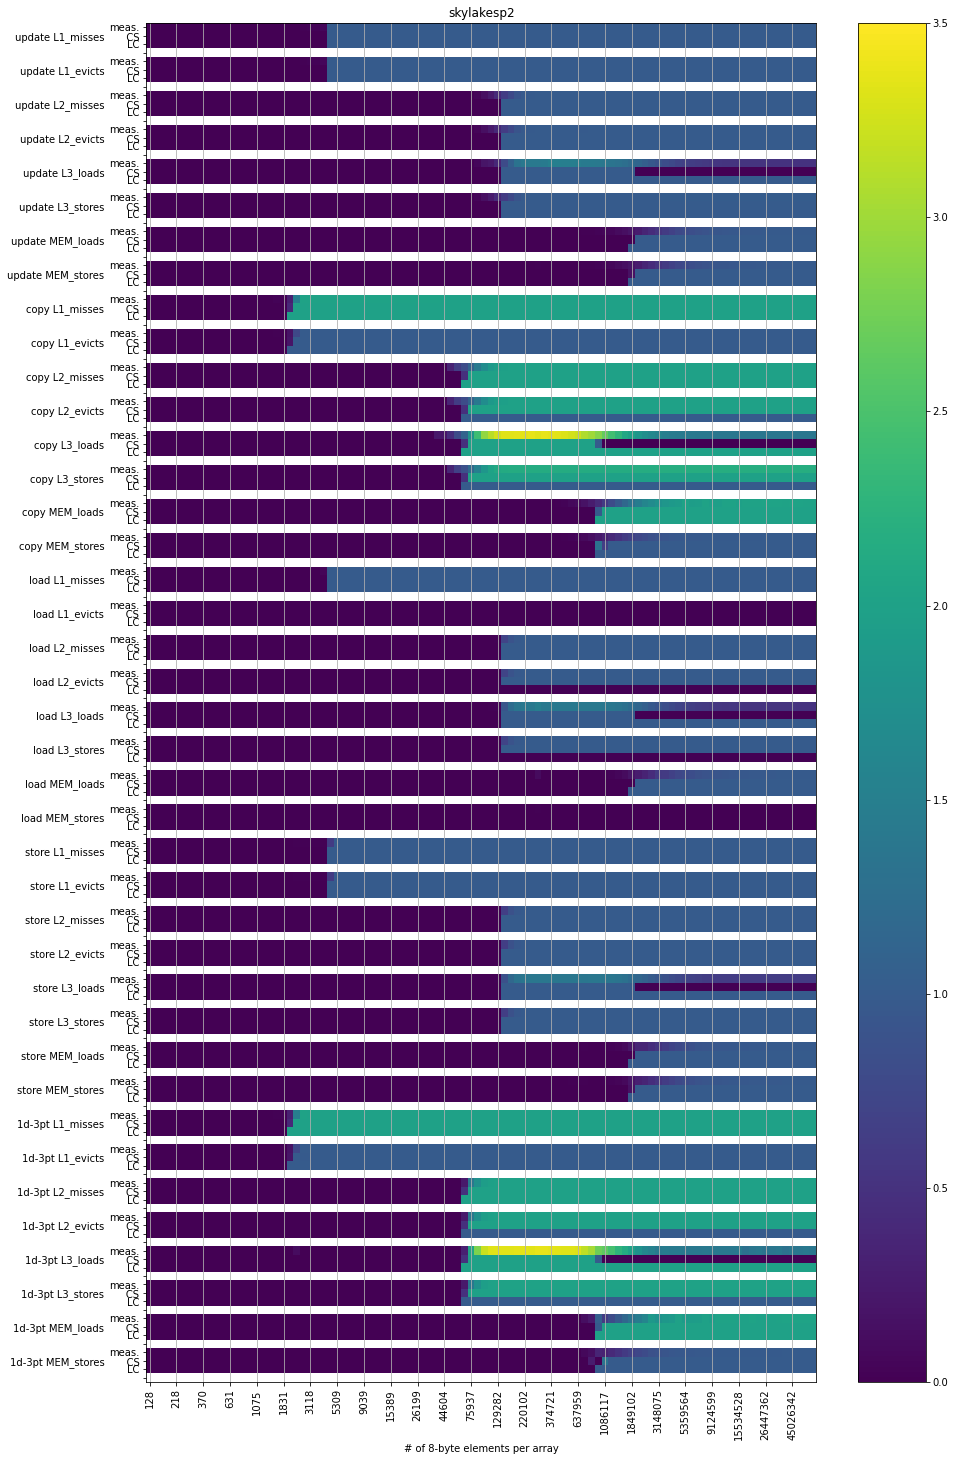

In [6]:
plotlinear('skylakesp2', ['L1_misses', 'L1_evicts', 'L2_misses', 'L2_evicts', 'L3_loads', 'L3_stores', 'MEM_loads', 'MEM_stores'])

Both AMD architectures presented here, `rome1` (Zen2) and `naples1` (Zen1) are unable to measure evicts on any cache level. They are also unable to differentiate between loads and store in memory and can only measure the sum of both.

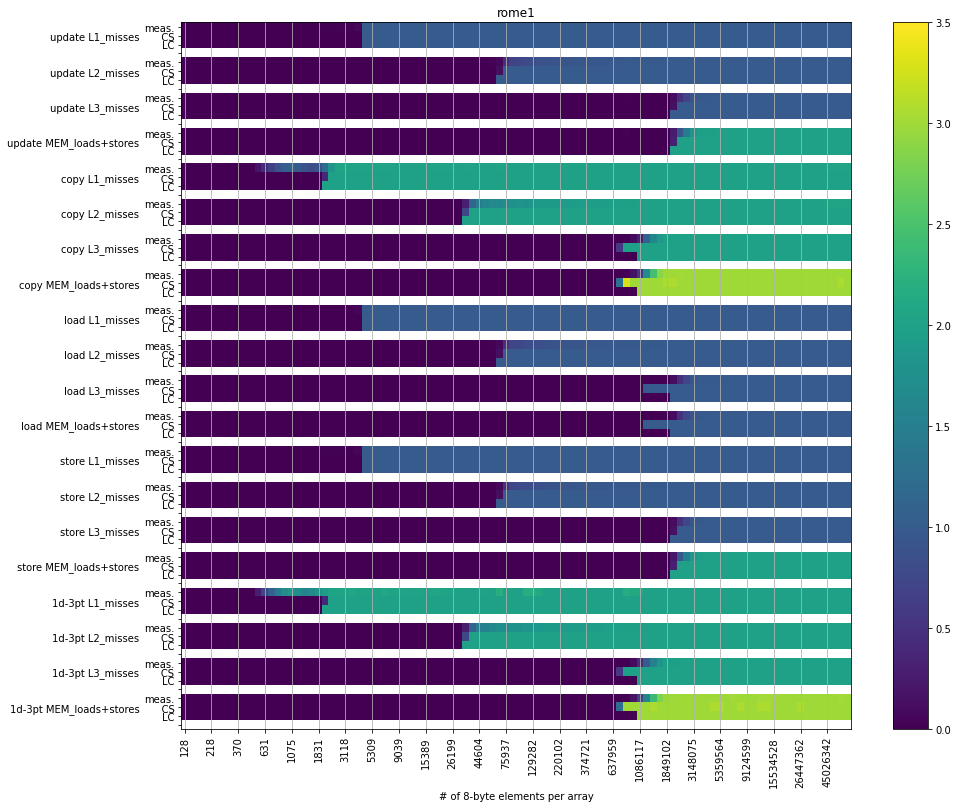

In [7]:
plotlinear('rome1', ['L1_misses', 'L2_misses', 'L3_misses', 'MEM_loads+stores'])  # evicts and stores not measurable

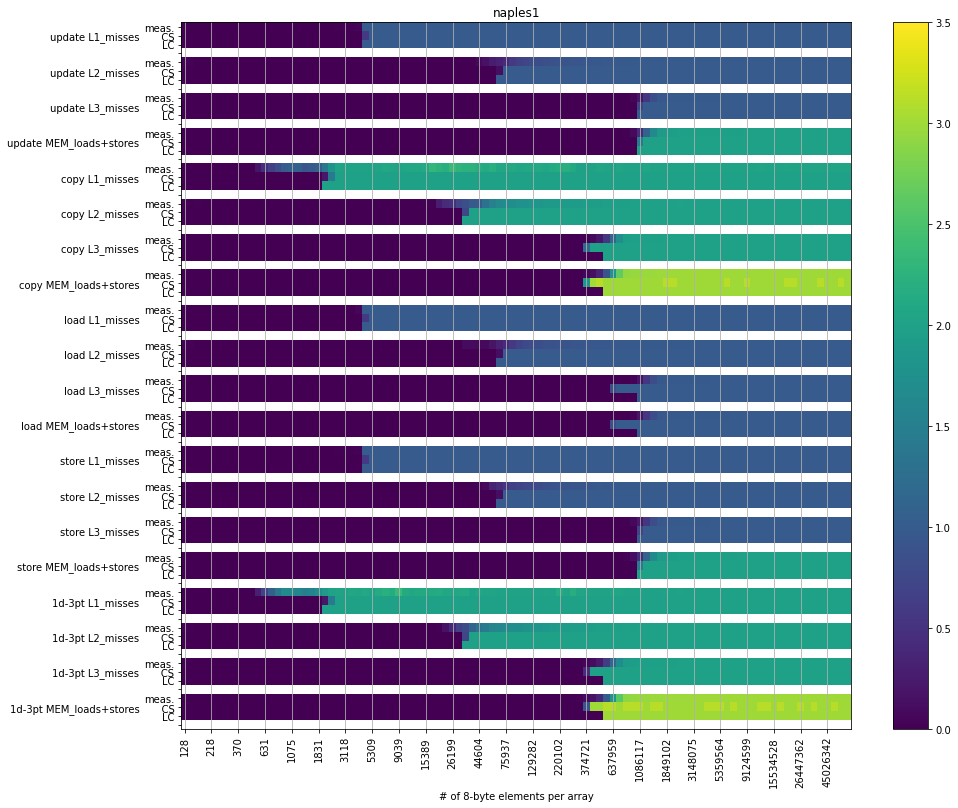

In [8]:
plotlinear('naples1', ['L1_misses', 'L2_misses', 'L3_misses', 'MEM_loads+stores'])  # evicts and stores not measurable

`warmup` seems to support write-combining and thus eliminating write-allocates between the L1 and L2 cache. This is observed in `L2_misses` and `L3_misses` for kernels with write-allocates (`copy`, `store`, `1d-3pt`). The different predictions for `L2_evicts` between CS, which is alwasy correct, and LC, off by one cacheline for kernels with load-only streas (`copy`, `load`, `1d-3pt`) is based on the victim-cache nature of the L3, which can not be predicted by the LC model. 

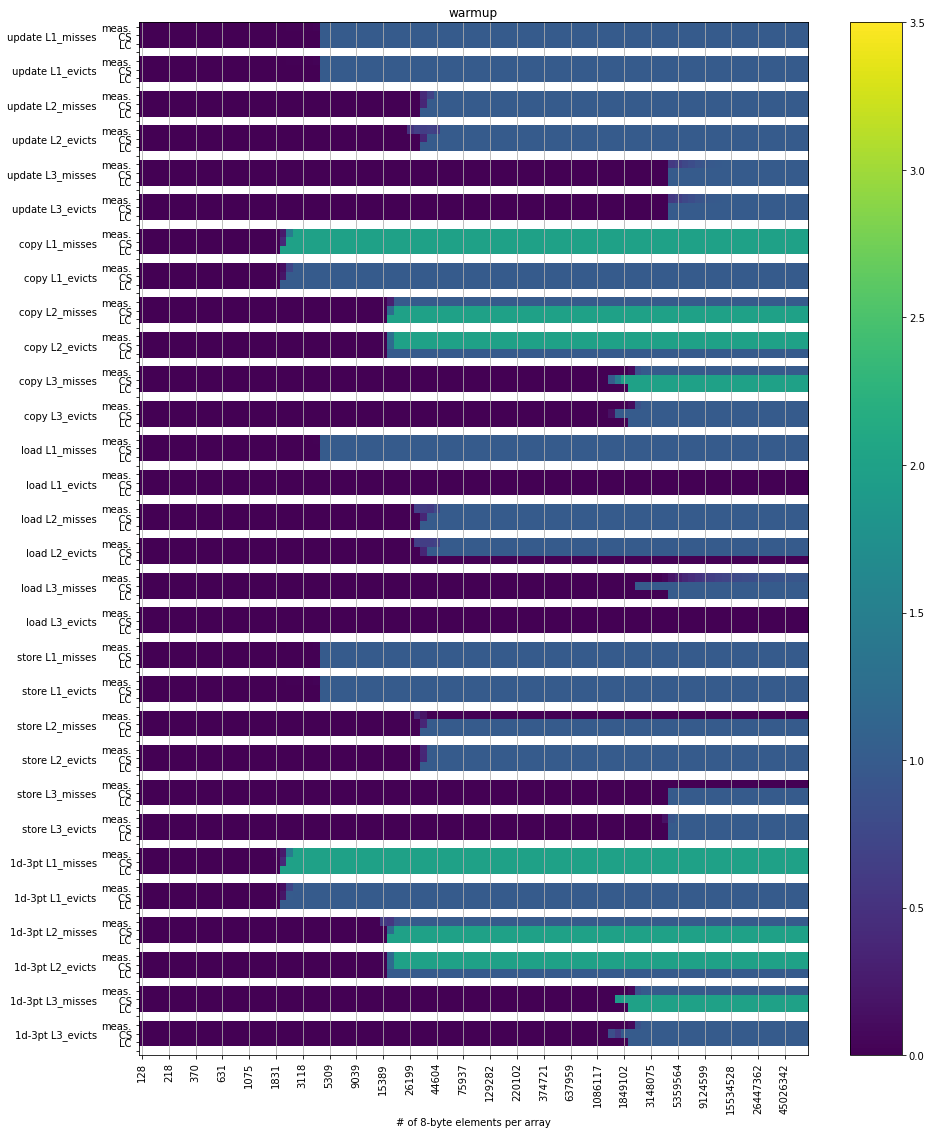

In [9]:
plotlinear('warmup', ['L1_misses', 'L1_evicts', 'L2_misses', 'L2_evicts', 'L3_misses', 'L3_evicts'])

`qpace4` (A64FX) has no L3 cache and a straight-forward linear cache architecture, which allows close-to-perfect predictions.

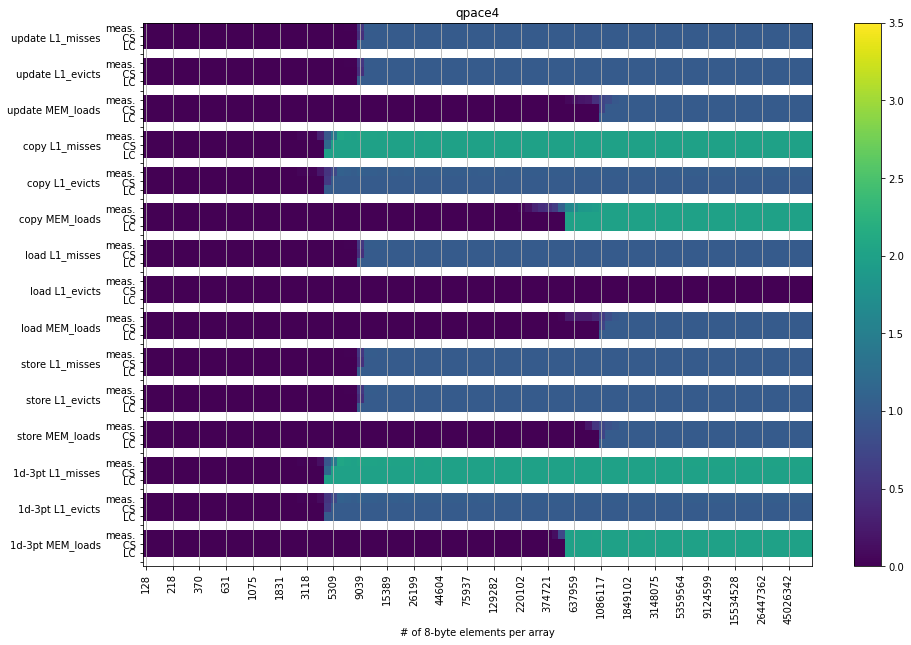

In [10]:
plotlinear('qpace4', ['L1_misses', 'L1_evicts', 'MEM_loads'])  # no L3

In the following plots, along the x-axis is the length of the array(s), in 8-byte elements. The y-axis shows the number of missed (which had transfered **from** the next lower level) or evicted (which were transfered **to** the next lower level) cachelines per eight iterations. Eight elements make up one cacheline on all but the A64FX architecture.

In [11]:
def plot1d(source):
    hosts = sorted(df.hostname.unique())
    kernels = ['update', 'copy', 'load', 'store', '1d-3pt']
    columns = ['L1_misses', 'L1_evicts', 'L2_misses', 'L2_evicts', 'L3_loads', 'L3_stores', 'MEM_loads', 'MEM_stores']
    vmax = df.query("source == @source and kernel in @kernels")[columns].max().values.max()
    fig, axs = plt.subplots(len(hosts), len(kernels), squeeze=False, figsize=(20,13), sharex=True, sharey=True)
    fig.suptitle(source, y=0.95, fontsize=18)
    styles = []
    for ih, h in enumerate(hosts):
        for ik, k in enumerate(kernels):
            ax = df.query("source == @source and kernel == @k and hostname == @h").plot(
                y=columns,
                x='dimension_0',
                xlabel='',
                logx=True,
                style='-',
                ax=axs[ih, ik],
                legend=False,
                title="{} {}".format(h, k))
            if ik == 0:
                axs[ih,ik].set_ylabel("cachelines per\n8 iterations")
            ax.grid(axis='y')
    fig.legend(
        [c.replace("_", " ") for c in columns],
        ncol=6,
        loc='lower center')

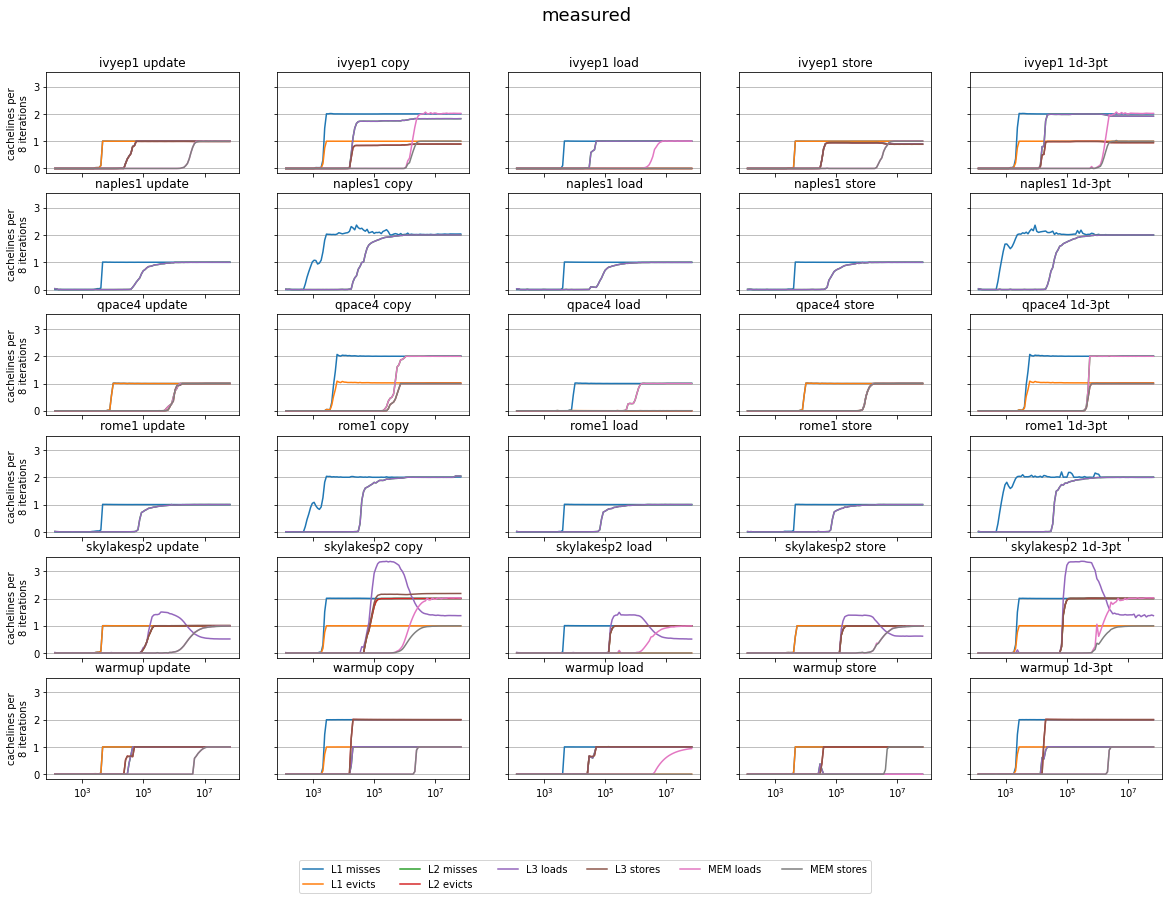

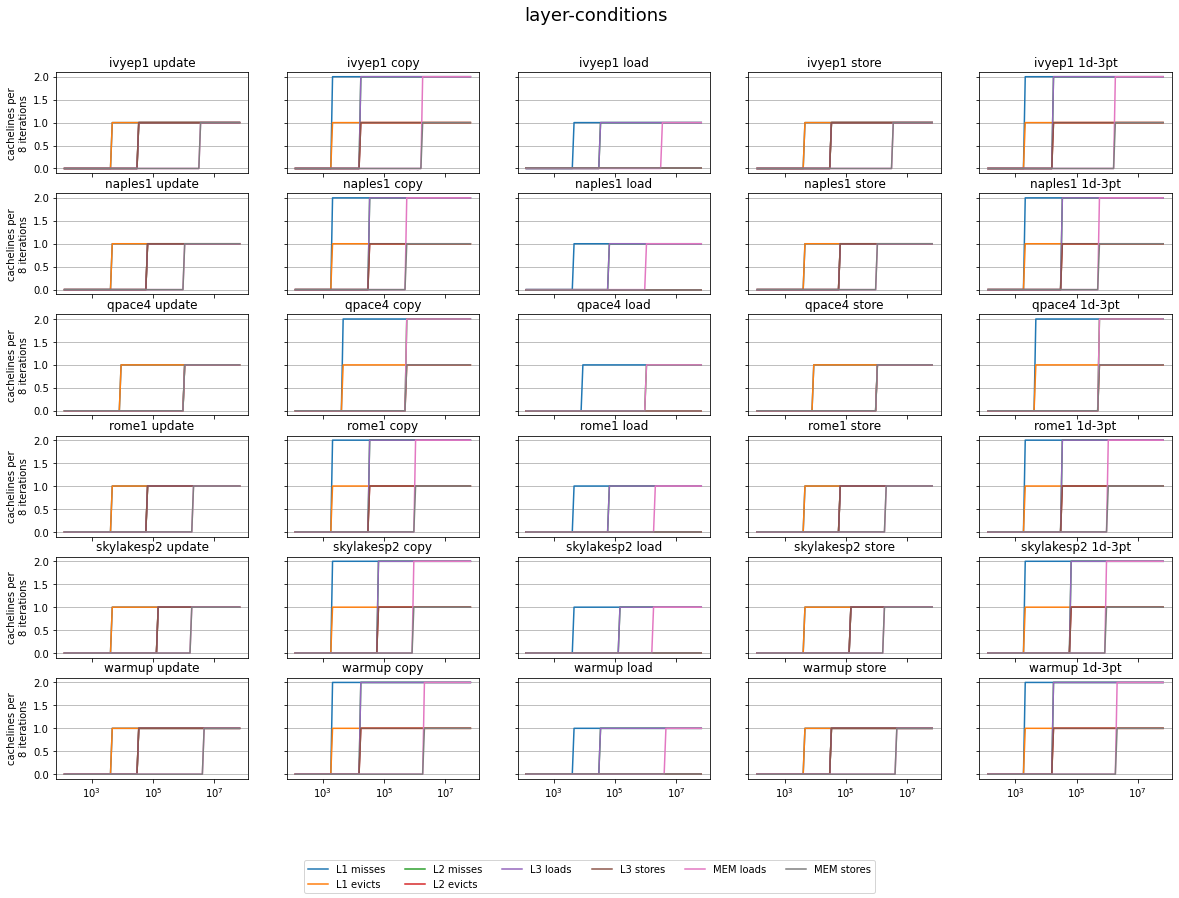

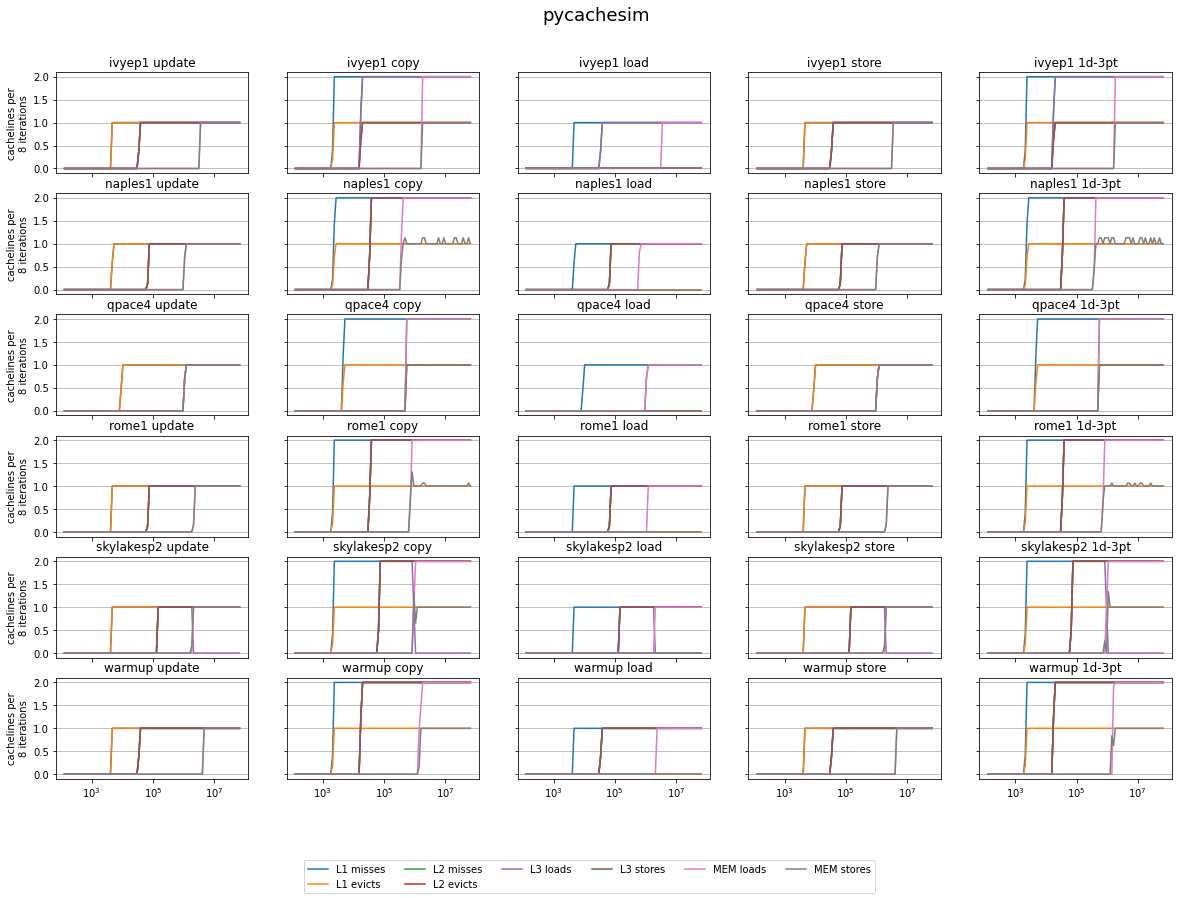

In [12]:
plot1d('measured')
plot1d('layer-conditions')
plot1d('pycachesim')

## 2D and 3D Kernels
These kernels are based on matrices/fields, where the length of each dimension are parameters. Plotting these in 2D on a log-log scaled grid shows the whole traversed parameter space. The parameter space is limited by the total data size, which was capped at one gigabyte, leaving the top right area untreversed.

The colors are the missed cachelines per eight iterations. Except for `rome1` and `naples1` in the `MEM` row, there stores and loads are considered combined, because they can not be distingued during measurement.

In [13]:
def build_const_int_cmap(vmin, vmax, consts=None, const_range=0.1, base_cmap='viridis', segments=512):
    """
    Construct linear colormap with constant color segments.
    
    colors are kept constant around:
     * consts values (const +- const_range)
     * vmin (vmin + const_range)
     * vmax (vmax - const_range)
    """
    if consts is None:
        consts = list(range(math.ceil(vmin), math.floor(vmax)))
    # Color list marks regions which are to keep color constant ('c') or linear/sequential ('l')
    colorlist = ''
    for s in np.linspace(vmin, vmax, segments) - (vmax-vmin)/segments/2:
        if vmin+const_range > s or s > vmax-const_range:
            colorlist += 'c'
        elif any([c-const_range < s < c+const_range for c in consts]):
            colorlist += 'c'
        else:
            colorlist += 'l'
    linear_colorlist = mpl.cm.get_cmap(base_cmap, segments)(
        np.linspace(0, 1, segments))
    final_colorlist = []
    j = 0
    cur_seg = ''
    cur_color = None
    for i, s in enumerate(colorlist):
        if s == 'c' and cur_seg != 'c':
            # find center location of const range
            const_length = 0
            for c in colorlist[i:]:
                if c == 'c':
                    const_length += 1
                else:
                    break
            cur_color = linear_colorlist[i + const_length // 2]
        elif s == 'c':
            final_colorlist.append(cur_color)
        else:
            final_colorlist.append(linear_colorlist[i])
        cur_seg = s
    return mpl.colors.ListedColormap(final_colorlist)

In [14]:
def plot2d(kernel, source, xcol='dimension_2', ycol='dimension_1', vmin=None, vmax=None, base_cmap='rainbow'):
    pltdata = df.query("kernel == @kernel and source == @source").sort_values(xcol)
    hosts = sorted(df.hostname.unique())
    caches = ['L2', 'L3', 'MEM']
    values = pltdata[[c+"_loads" for c in caches]+["MEM_loads+stores"]].values.astype('float64')
    values = np.ma.array(values, mask=np.isnan(values))
    vmin_data = math.floor(values.min())
    if vmin is None:
        vmin = vmin_data
    vmax_data = math.floor(values.max())
    if vmax is None:
        vmax = vmax_data
    cmap = build_const_int_cmap(vmin, vmax, base_cmap=base_cmap)
    ys = sorted(pltdata[ycol].unique())
    xs = sorted(pltdata[xcol].unique())
    fig, axs = plt.subplots(len(caches), len(hosts), figsize=(20,10), squeeze=False, sharex=True, sharey=True)
    fig.suptitle(f"{kernel} {source}", y=0.95, fontsize=20)
    for i, h in enumerate(hosts):
        for j, c in enumerate(caches):
            if j == 0:
                axs[j,i].set_title(h)
            if i == 0:
                axs[j,i].set_ylabel(c, rotation=0)
            imdata = np.empty((len(ys), len(xs)))
            imdata.fill(float('nan'))
            d = pltdata.query("hostname == @h")
            for yi, y in enumerate(ys):
                if h in ['rome1', 'naples1'] and c == 'MEM':
                    row = d.query(ycol+' == @y')[c+'_loads+stores'].values.transpose()
                else:
                    row = d.query(ycol+' == @y')[c+'_loads'].values.transpose()
                imdata[yi,:len(row)] = row
            im = axs[j,i].imshow(imdata, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower', interpolation='nearest')
            axs[j,i].set_yticks(range(0, len(ys), 4))
            axs[j,i].set_yticks(range(len(ys)), minor=True)
            axs[j,i].set_yticklabels([int(y) for y in ys][::4])
            axs[j,i].set_xticks(range(0, len(xs), 4))
            axs[j,i].set_xticks(range(len(xs)), minor=True)
            axs[j,i].set_xticklabels([int(x) for x in xs][::4], rotation=90)
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=range(math.floor(vmin), math.floor(vmax)+1),
                        label="cache lines serverd per 8 iterations")
    tl = [str(t) for t in range(math.floor(vmin), math.floor(vmax)+1)]
    if vmax < vmax_data:
        tl[-1] = '≥' + tl[-1]
    if vmin > vmin_data:
        tl[0] = '≤' + tl[0]
    cbar.set_ticklabels(tl)
    return fig, axs

In [15]:
def plot2derr(axsa, axsb, title="", v=2):
    hosts = sorted(df.hostname.unique())
    caches = ['L2', 'L3', 'MEM']
    fig, axs = plt.subplots(len(caches), len(hosts), figsize=(20,10), squeeze=False, sharex=True, sharey=True)
    fig.suptitle(title, y=0.95, fontsize=20)
    sub_minerr, sup_maxerr = False, False
    for i, h in enumerate(hosts):
        for j, c in enumerate(caches):
            if j == 0:
                axs[j,i].set_title(h)
            if i == 0:
                axs[j,i].set_ylabel(c)
                
            datam = axsa[j,i].get_images()[0].get_array().data
            datap = axsb[j,i].get_images()[0].get_array().data
            s = (min(datap.shape[0], datam.shape[0]), min(datap.shape[1], datam.shape[1]))
            err = datap[:s[0],:s[1]]-datam[:s[0],:s[1]]
            if np.ma.array(err, mask=np.isnan(err)).max() > v:
                sup_maxerr = True
            if np.ma.array(err, mask=np.isnan(err)).max() < -v:
                sub_minerr = True
            abserr_nanmasked = np.ma.array(abs(err), mask=np.isnan(err))
            im = axs[j,i].imshow(err, cmap="PiYG", vmin=-v, vmax=v, origin='lower')
            avg_abserr = abserr_nanmasked.sum() / abserr_nanmasked.count()
            if isinstance(avg_abserr, float):
                axs[j,i].annotate(f"avg(abserr)={avg_abserr:.2}",
                                  xy=(1, 1), xycoords='axes fraction',
                                  horizontalalignment='right', verticalalignment='top',
                                  color='red', backgroundcolor='white')
            axs[j,i].set_yticks([])
            axs[j,i].set_xticks([])
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax,
                        label="absolute deviation in cache lines per 8 iterations (prediction - measurement)")
    cbar.set_ticks(range(-v, v+1))
    tl = [str(t) for t in range(-v, v+1)]
    if sup_maxerr:
        tl[-1] = '≥' + tl[-1]
    tl[-1] += " (too much\n pred.)"
    if sub_minerr:
        tl[0] = '≤' + tl[0]
    tl[0] += " (too little\n pred.)"
    cbar.set_ticklabels(tl)

## `2d-5pt` Kernel
The x-axis are the length of the inner dimension (i.e., `cur_elementx`) and on the y-axis is the outer dimension length (i.e., `cur_elementsy`).
```c
for(int y=1; y<cur_elementsy-1; y++) {
    for(int x=1; x<cur_elementsx-1; x++) {
        a[y*cur_elementsx+x] =
            b[(y-1)*cur_elementsx+x] + 
            b[y*cur_elementsx+x-1] +
            b[y*cur_elementsx+x+1] +
            b[(y+1)*cur_elementsx+x];
    }
}
```

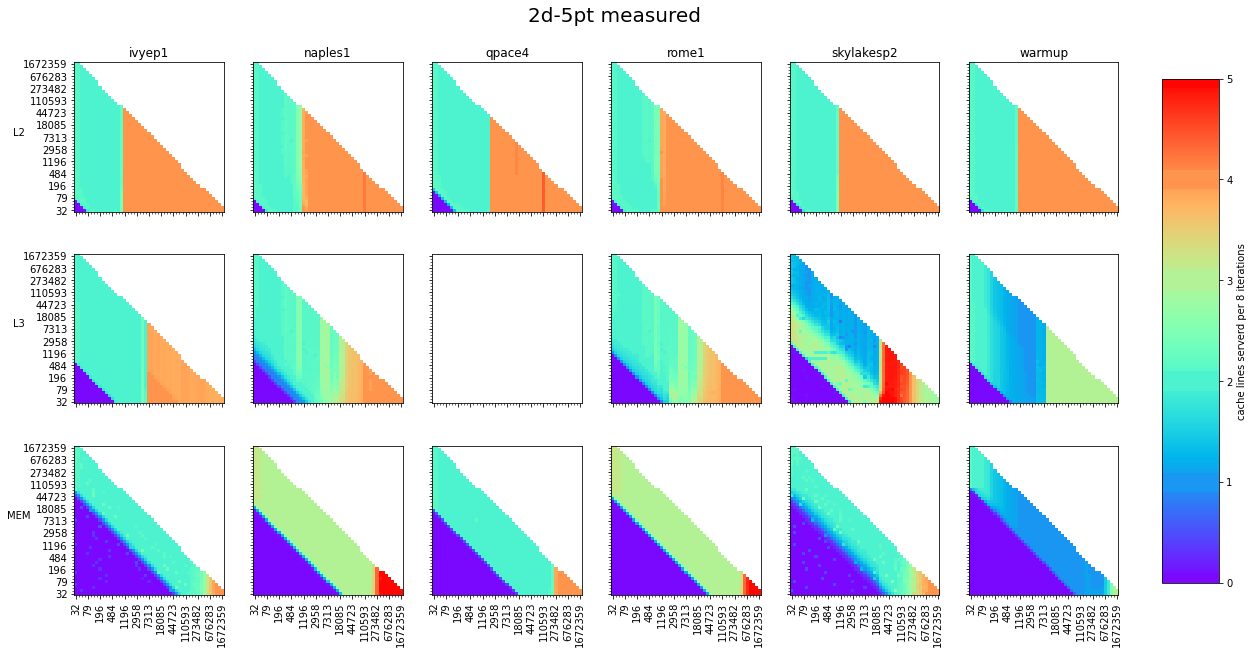

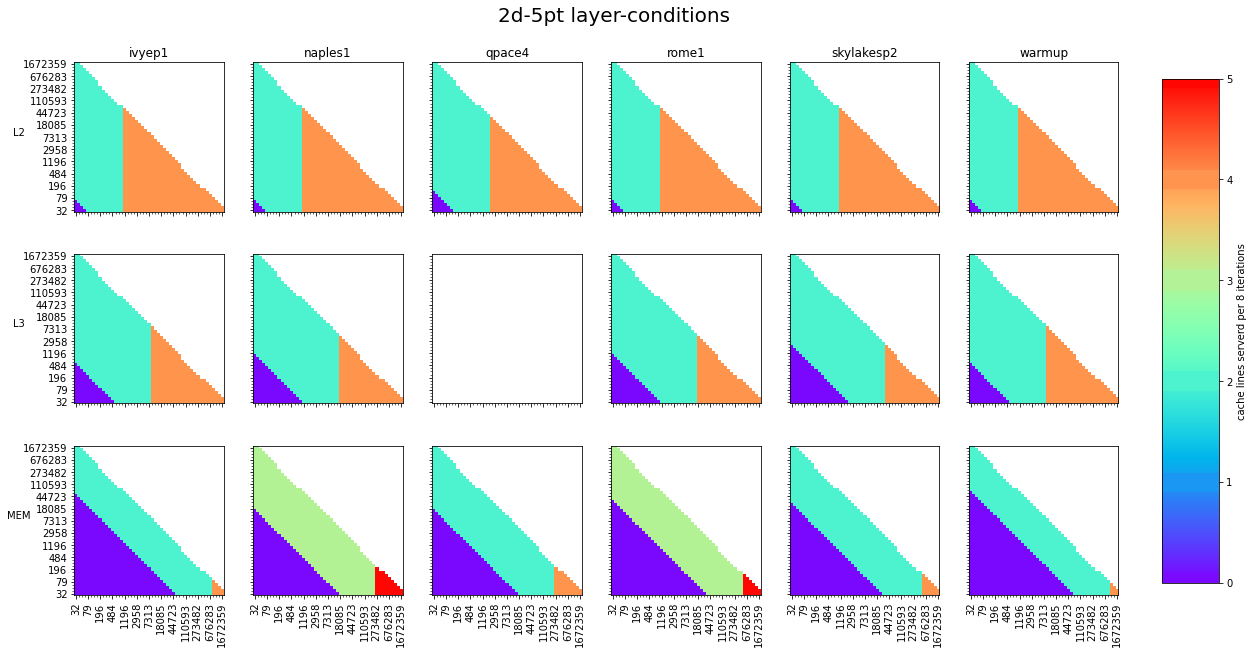

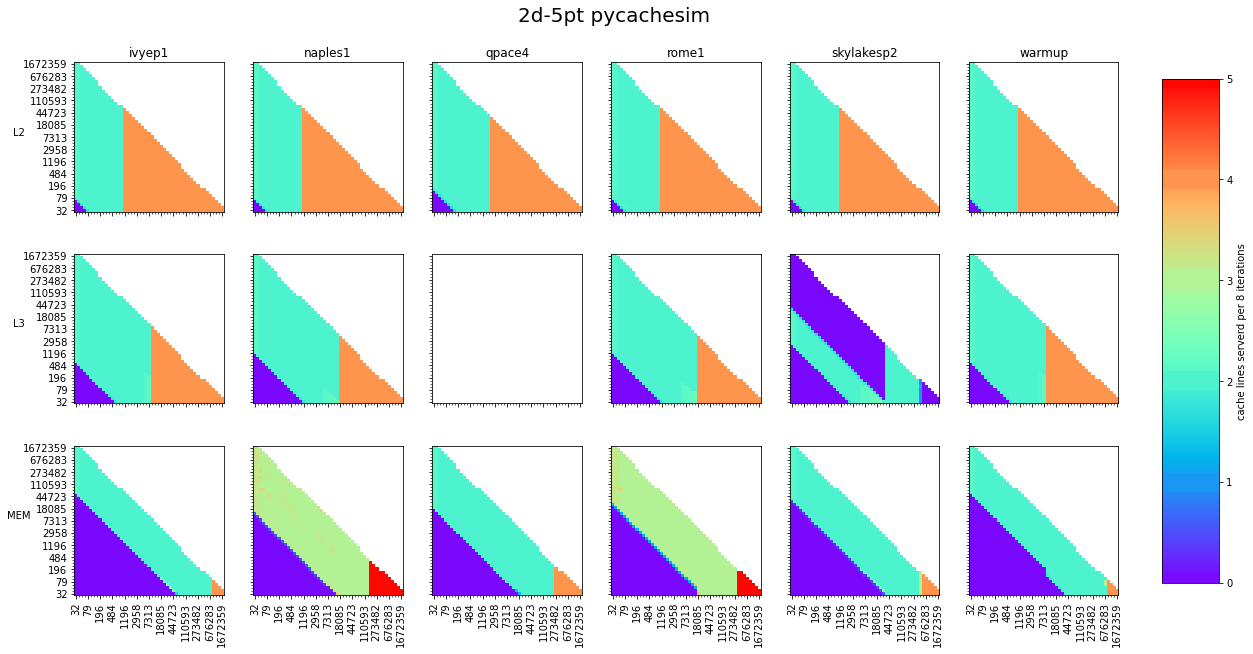

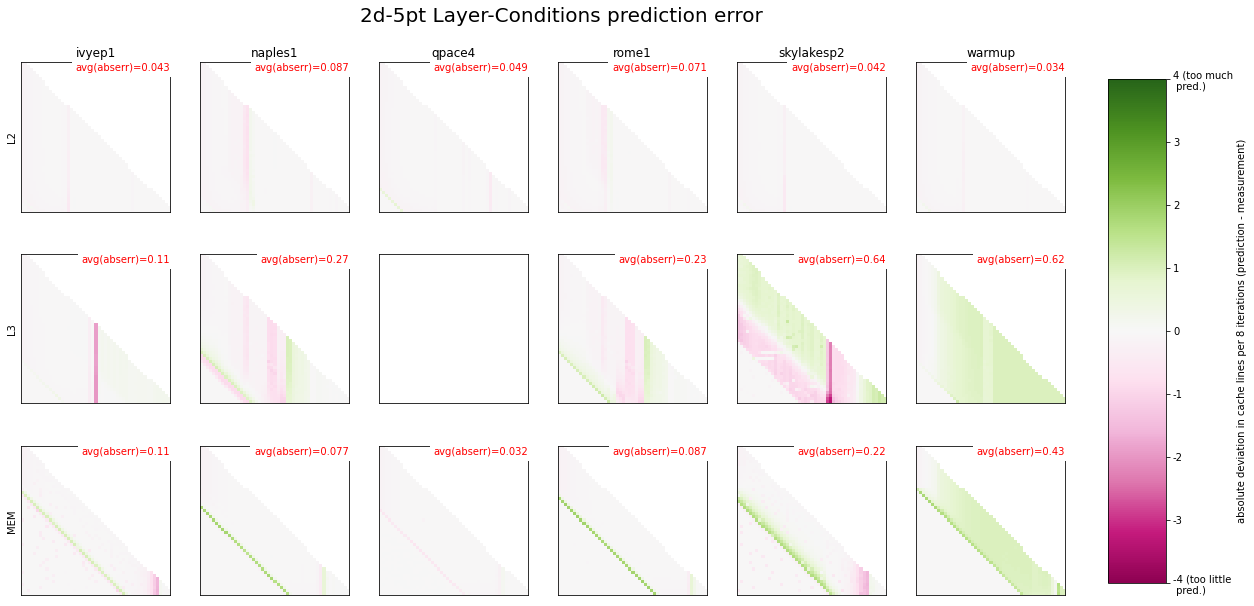

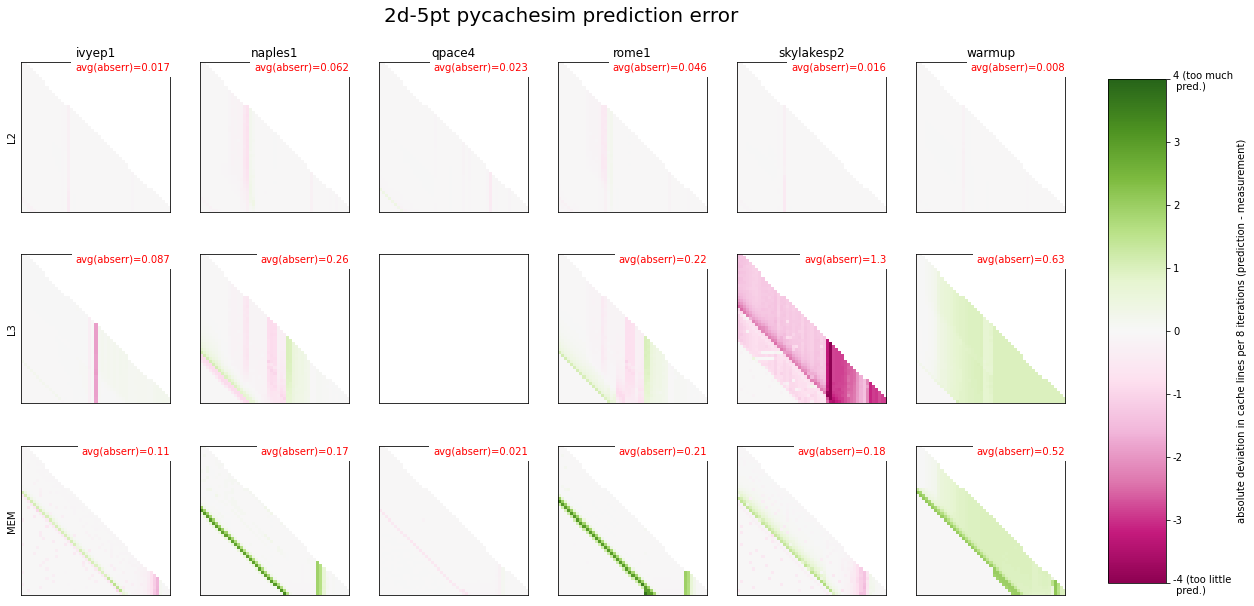

In [16]:
fas = {}
for source in ['measured', 'layer-conditions', 'pycachesim']:
    fas[source] = plot2d('2d-5pt', source, xcol='dimension_1', ycol='dimension_0', vmin=0, vmax=5)
plot2derr(fas['measured'][1], fas['layer-conditions'][1], "2d-5pt Layer-Conditions prediction error", v=4)
plot2derr(fas['measured'][1], fas['pycachesim'][1], "2d-5pt pycachesim prediction error", v=4)

## `matvec` Kernel

y-axis is rows (i.e., `cur_rows`), x-axis is columns (i.e., `cur_cols`) of matrix and length of vectors.

!!! Layer-Conditions do not work here


$M*\vec{v} = \vec{r}$ with $M = rows \times cols$
```c
for(int r=1; r<cur_rows-1; r++) {
    double s = 0;
    for(int c=1; c<cur_cols-1; c++) {
        s += mat[r*cur_cols+c]*vec[c];
    }
    resv[r] = s;
}
```

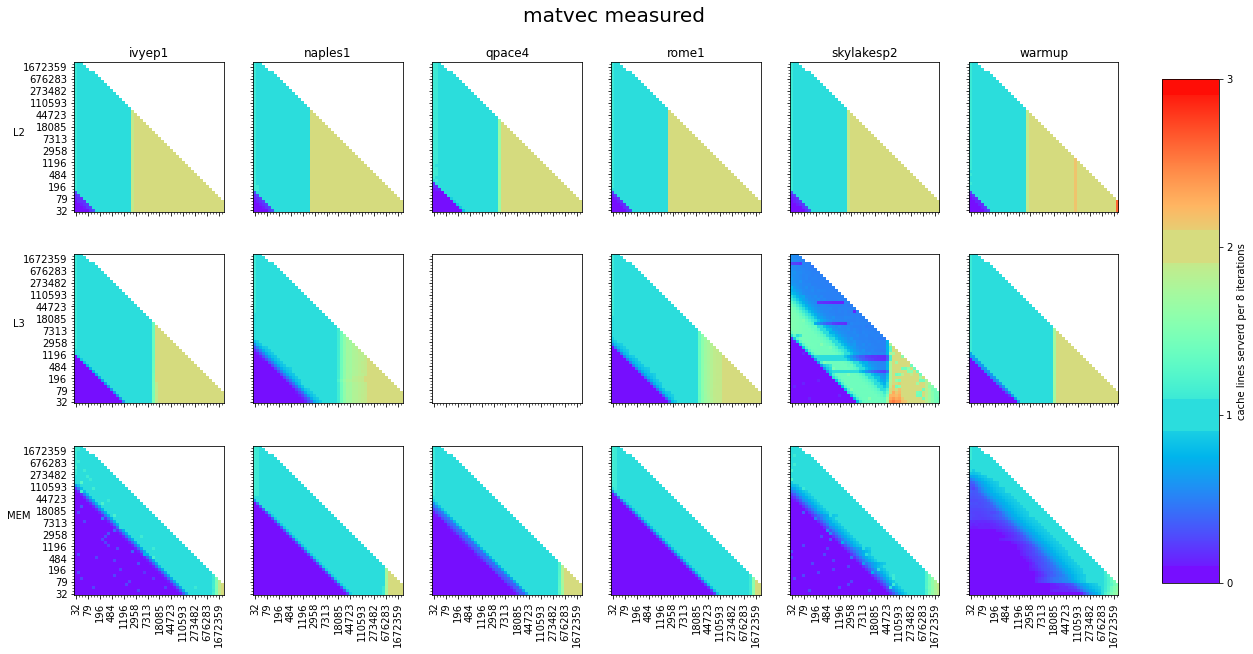

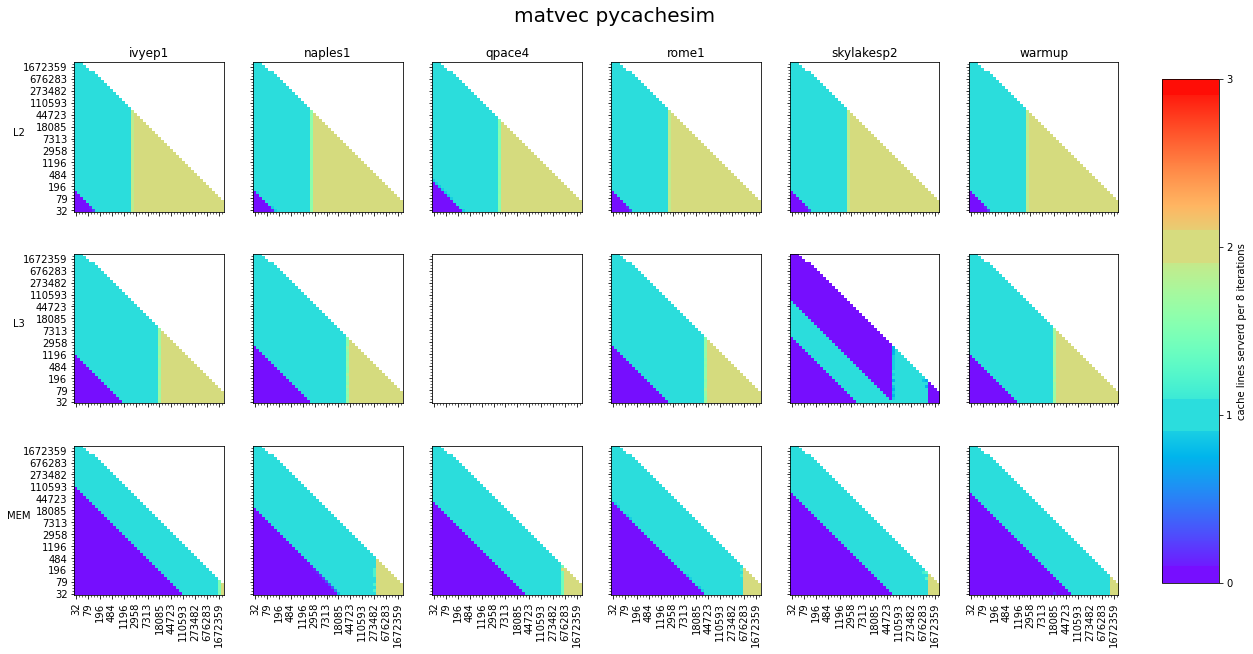

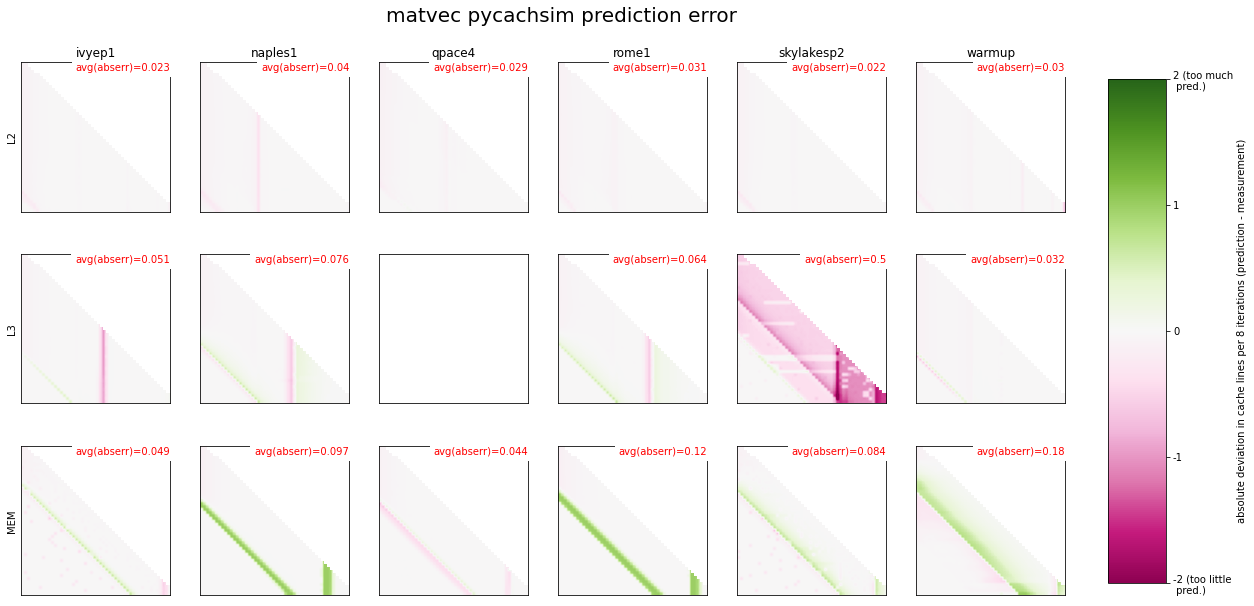

In [17]:
fas = {}
for source in ['measured', 'pycachesim']:
    fas[source] = plot2d('matvec', source, xcol='dimension_1', ycol='dimension_0', vmin=None, vmax=3)

plot2derr(fas['measured'][1], fas['pycachesim'][1], "matvec pycachsim prediction error", v=2)

## `transmatvec` Kernel
x-axis is rows (i.e., `cur_rows`), y-axis is columns (i.e., `cur_cols`) of original matrix (pre transposed, as layed out in memory) and length of vectors.

!!! layer-conditions do not work here

$M^T*\vec{v} = \vec{r}$ with $M = rows \times cols$

```c
for(int r=1; r<cur_rows-1; r++) {
    double s = 0;
    for(int c=1; c<cur_cols-1; c++) {
        s += mat[r+c*cur_rows]*vec[c];
    }
    resv[r] = s;
}
```

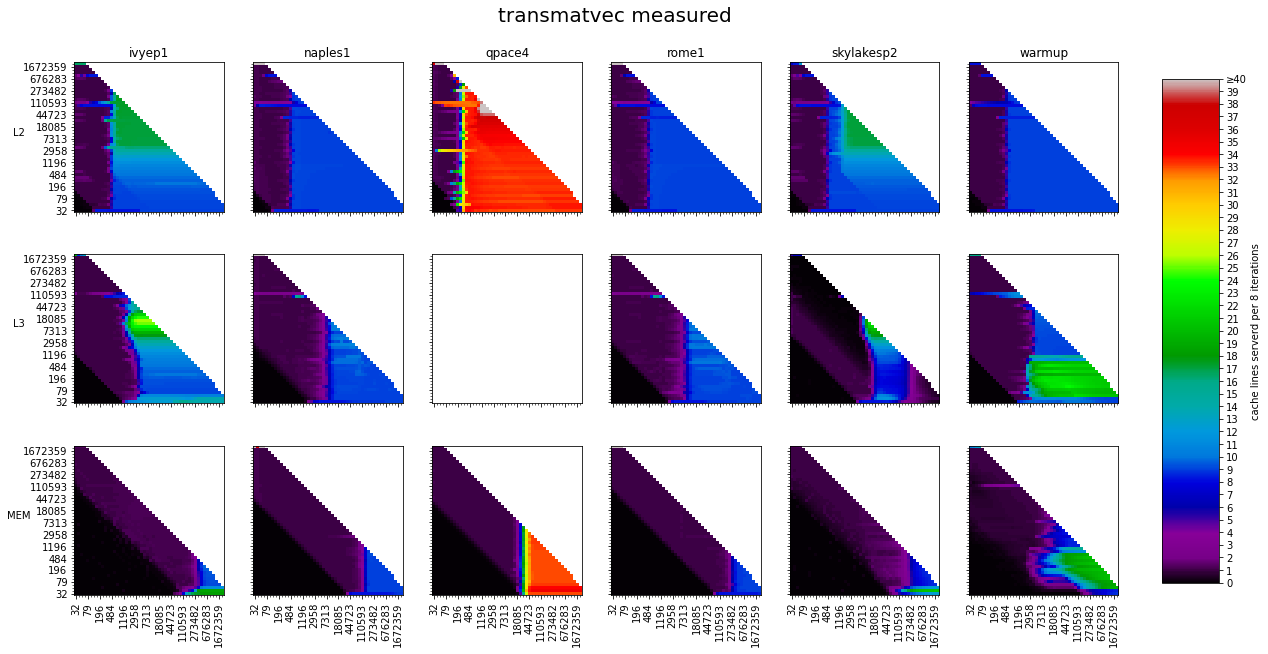

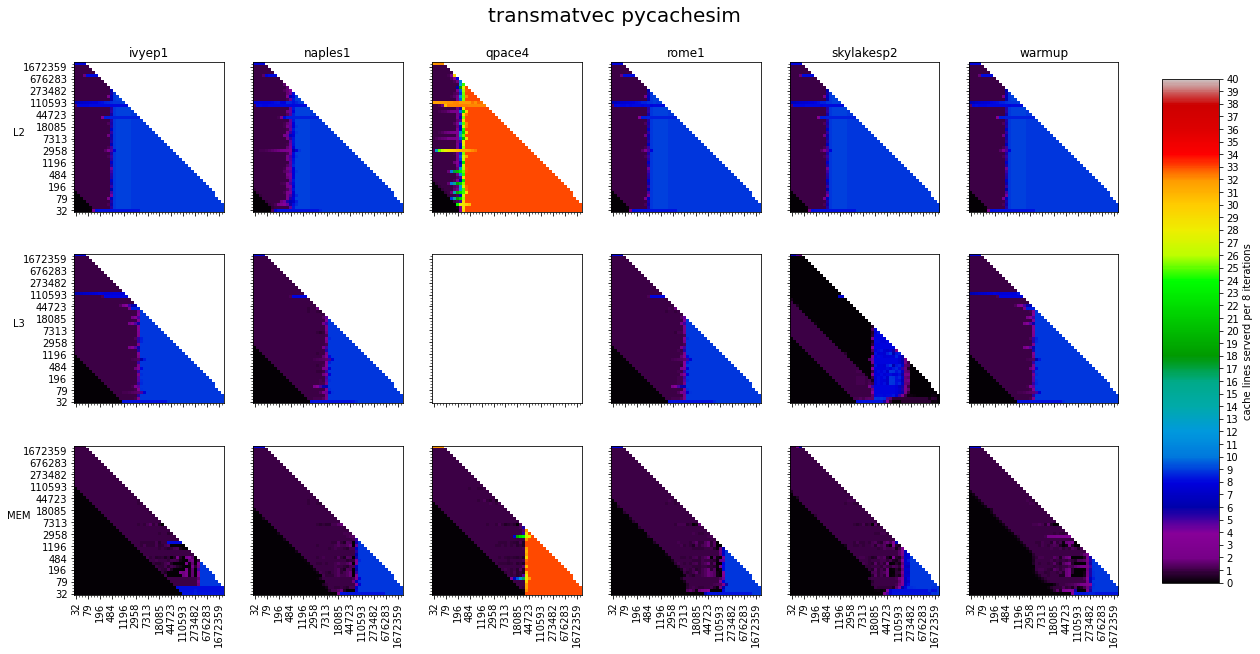

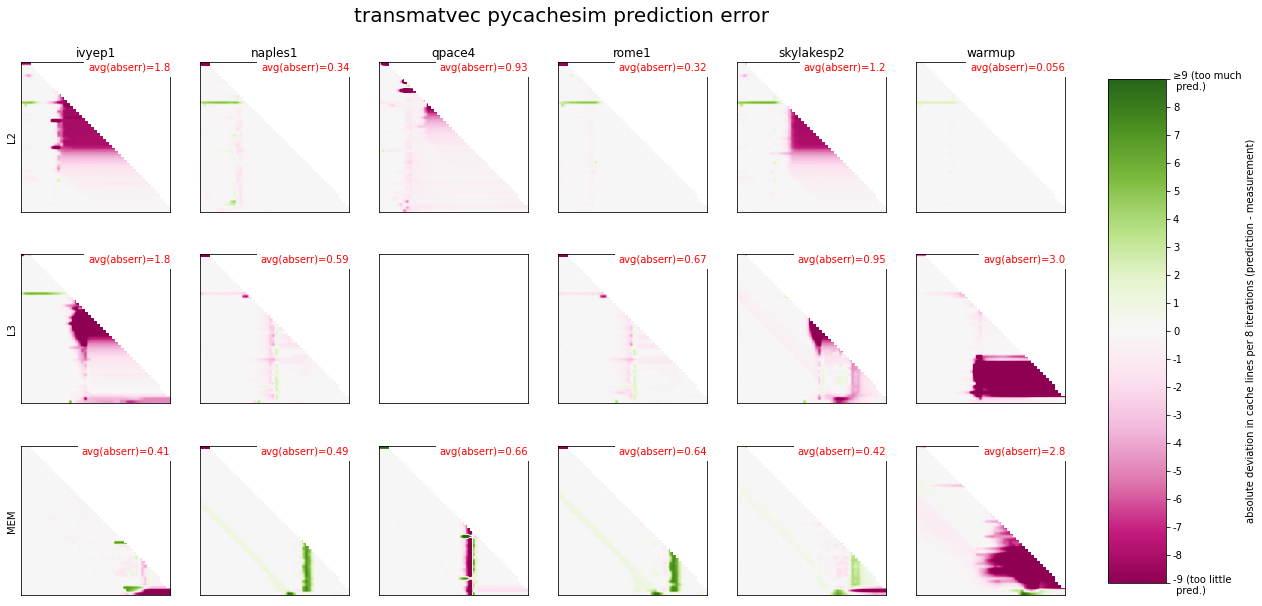

In [18]:
fas = {}
for source in ['measured', 'pycachesim']:
    fas[source] = plot2d('transmatvec', source, xcol='dimension_1', ycol='dimension_0',
                         vmin=None, vmax=40, base_cmap='nipy_spectral')
plot2derr(fas['measured'][1], fas['pycachesim'][1], "transmatvec pycachesim prediction error", v=9)

## 3d-7pt Kernel

For given inner array dimension $a$ and center dimension $b$, the outer dimension $c$ is selected such that the total dataset will not fit in the larges available cache. This formular is used: $2*\max(\mathrm{cache\_sizes}) \le a*b*c*8\,\mathrm{B} \le 8\,\mathrm{GiB}$.

```c
for(int z=1; z<cur_elementsz-1; z++) {
    for(int y=1; y<cur_elementsy-1; y++) {
        for(int x=1; x<cur_elementsx-1; x++) {
            a[z*cur_elementsy*cur_elementsx+y*cur_elementsx+x] =
                b[(z+1)*cur_elementsy*cur_elementsx+y*cur_elementsx+x] + 
                b[z*cur_elementsy*cur_elementsx+(y-1)*cur_elementsx+x] + 
                b[z*cur_elementsy*cur_elementsx+y*cur_elementsx+x-1] +
                b[z*cur_elementsy*cur_elementsx+y*cur_elementsx+x+1] +
                b[z*cur_elementsy*cur_elementsx+(y+1)*cur_elementsx+x] +
                b[(z-1)*cur_elementsy*cur_elementsx+y*cur_elementsx+x];
        }
    }
}
```

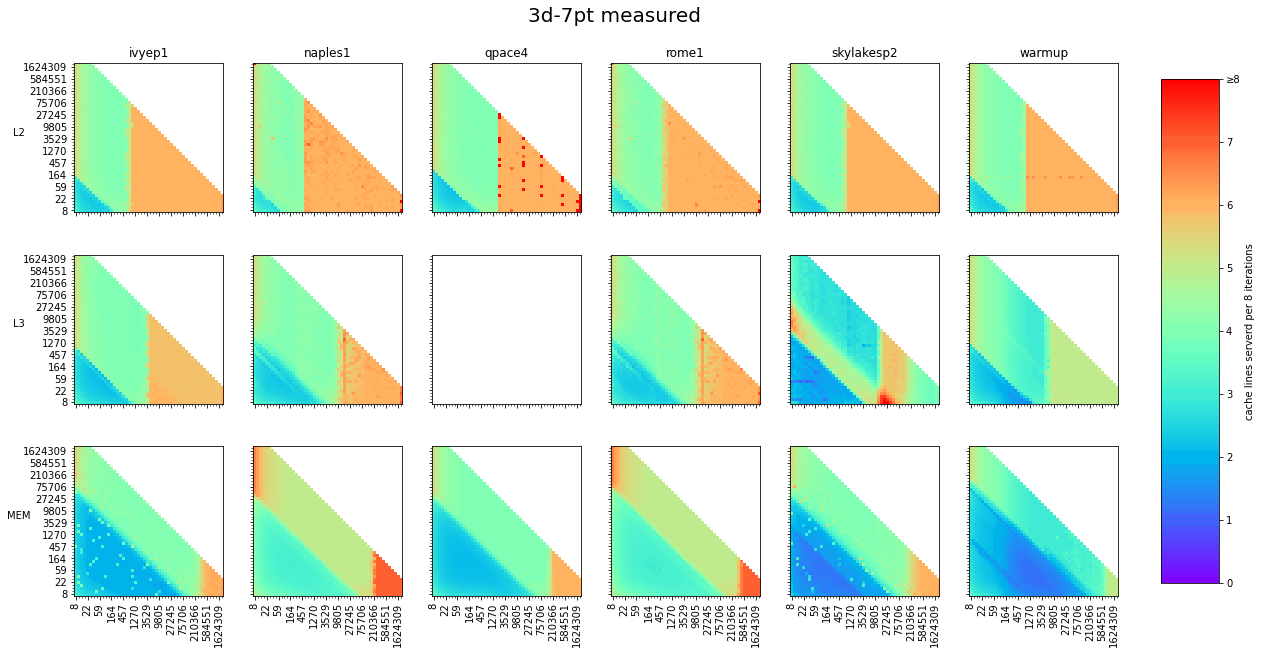

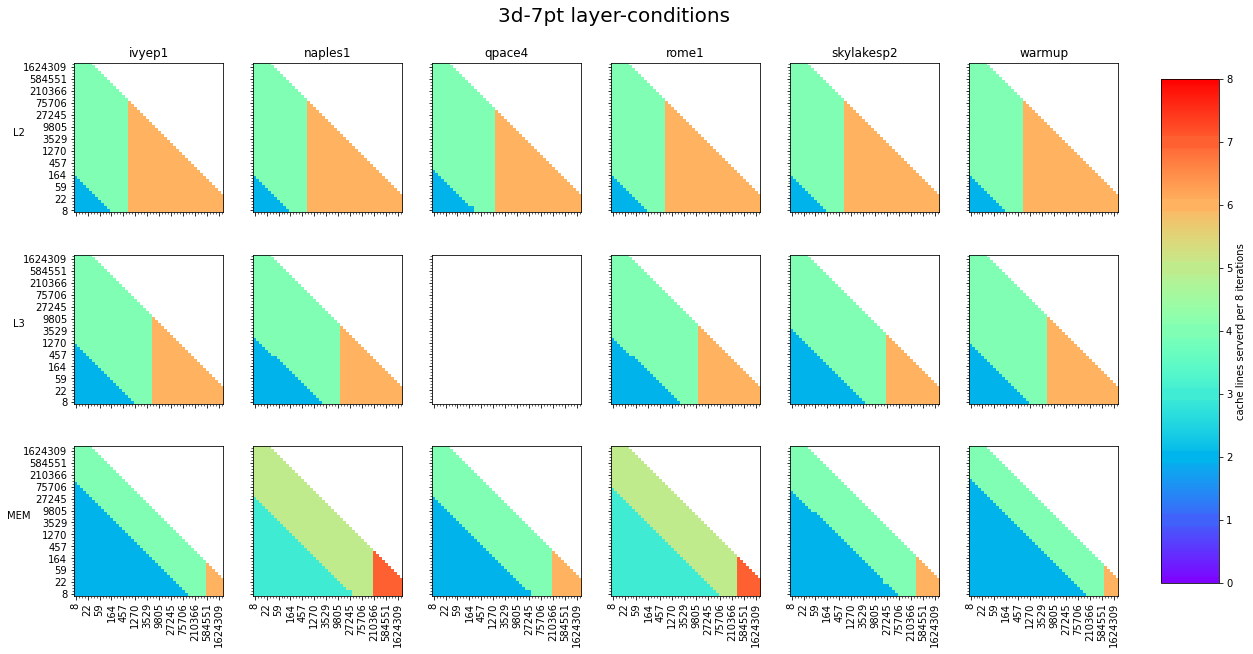

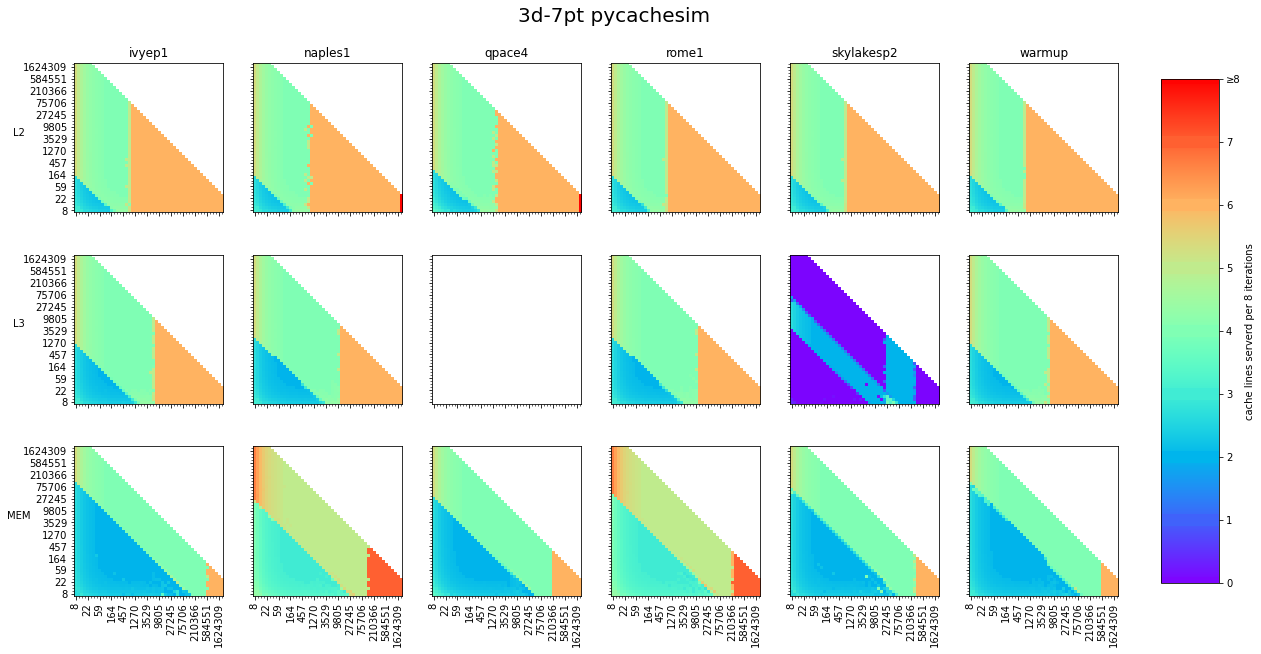

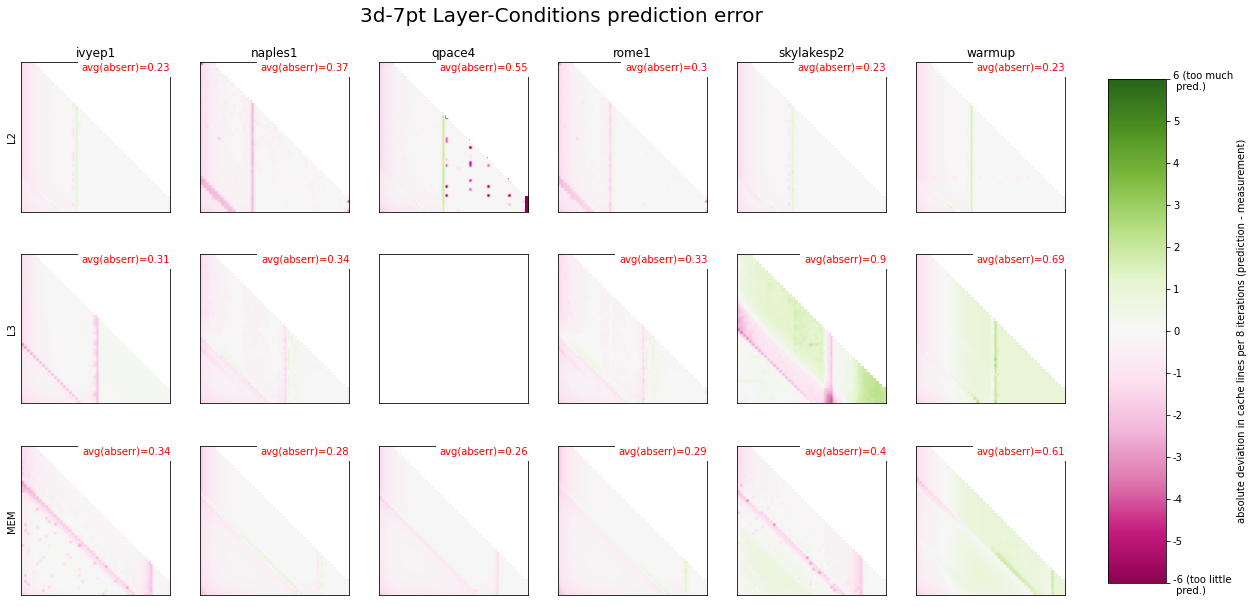

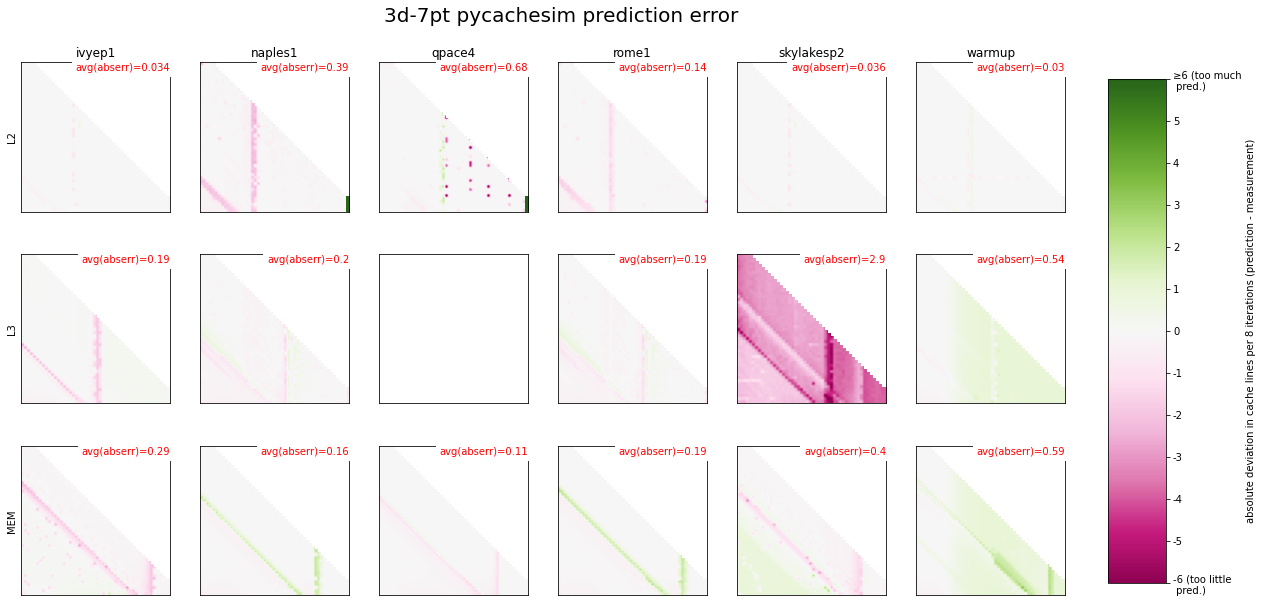

In [19]:
fas = {}
for source in ['measured', 'layer-conditions', 'pycachesim']:
    fas[source] = plot2d('3d-7pt', source, vmin=0, vmax=8)

plot2derr(fas['measured'][1], fas['layer-conditions'][1], "3d-7pt Layer-Conditions prediction error", v=6)
plot2derr(fas['measured'][1], fas['pycachesim'][1], "3d-7pt pycachesim prediction error", v=6)

## 3d-r3-11pt Kernel
This is a 3-dimensional star stencil, with a radius of 3. Although, only radius 1 and radius 3 have elements. The dataset size is scaled as described with the `3d-7pt` stencil.

```c
for(int z=3; z<cur_elementsz-3; z++) {
    for(int y=3; y<cur_elementsy-3; y++) {
        for(int x=1; x<cur_elementsx-1; x++) {
            a[z*cur_elementsy*cur_elementsx+y*cur_elementsx+x] =
                b[(z+3)*cur_elementsy*cur_elementsx+y*cur_elementsx+x] +
                b[(z+1)*cur_elementsy*cur_elementsx+y*cur_elementsx+x] +
                b[z*cur_elementsy*cur_elementsx+(y-3)*cur_elementsx+x] + 
                b[z*cur_elementsy*cur_elementsx+(y-1)*cur_elementsx+x] + 
                b[z*cur_elementsy*cur_elementsx+y*cur_elementsx+x-1] +
                b[z*cur_elementsy*cur_elementsx+y*cur_elementsx+x+1] +
                b[z*cur_elementsy*cur_elementsx+(y+1)*cur_elementsx+x] +
                b[z*cur_elementsy*cur_elementsx+(y+3)*cur_elementsx+x] +
                b[(z-1)*cur_elementsy*cur_elementsx+y*cur_elementsx+x] +
                b[(z-3)*cur_elementsy*cur_elementsx+y*cur_elementsx+x];
        }
    }
}
```

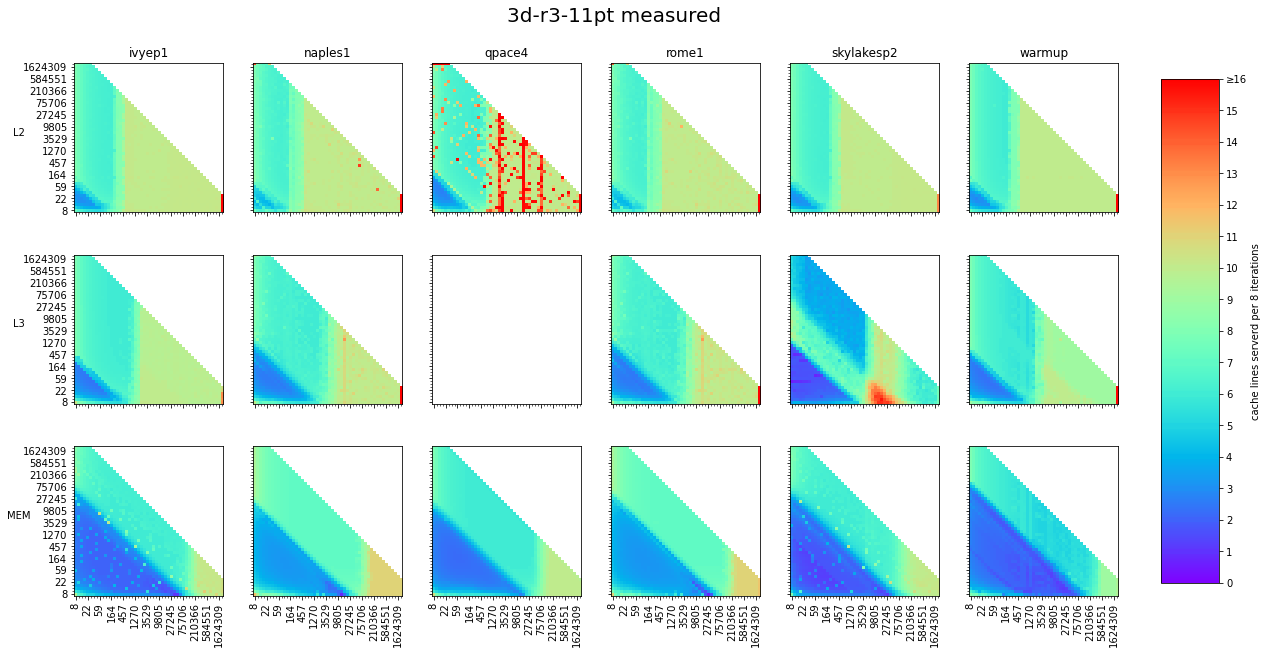

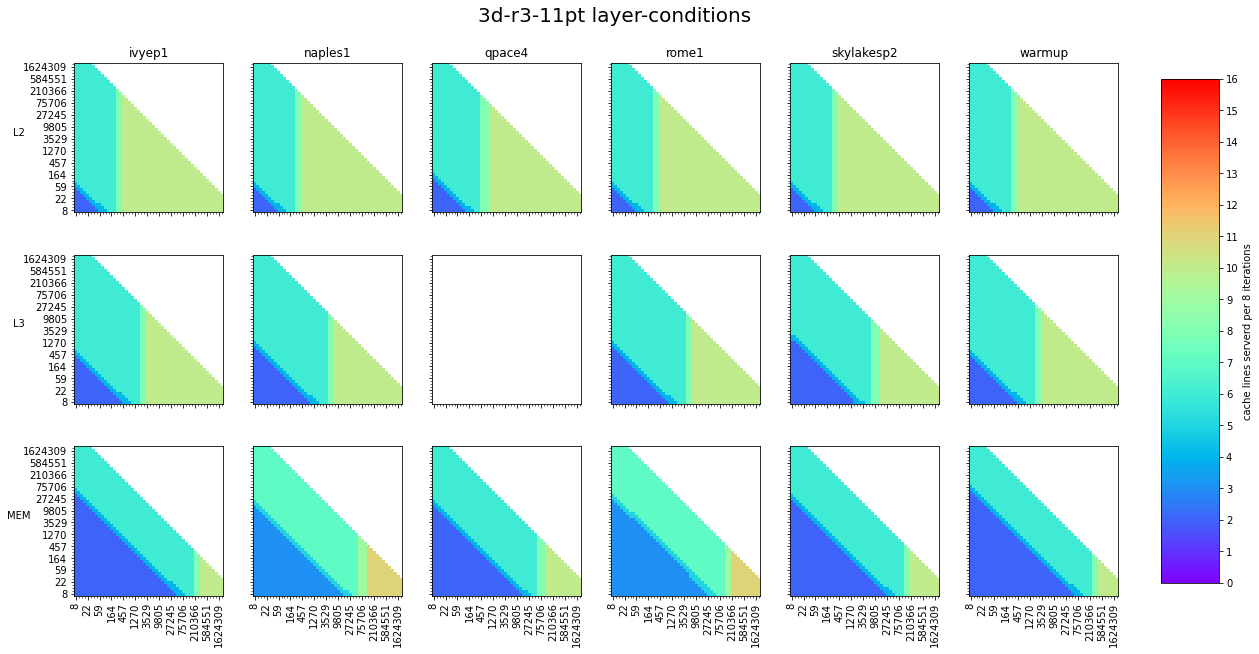

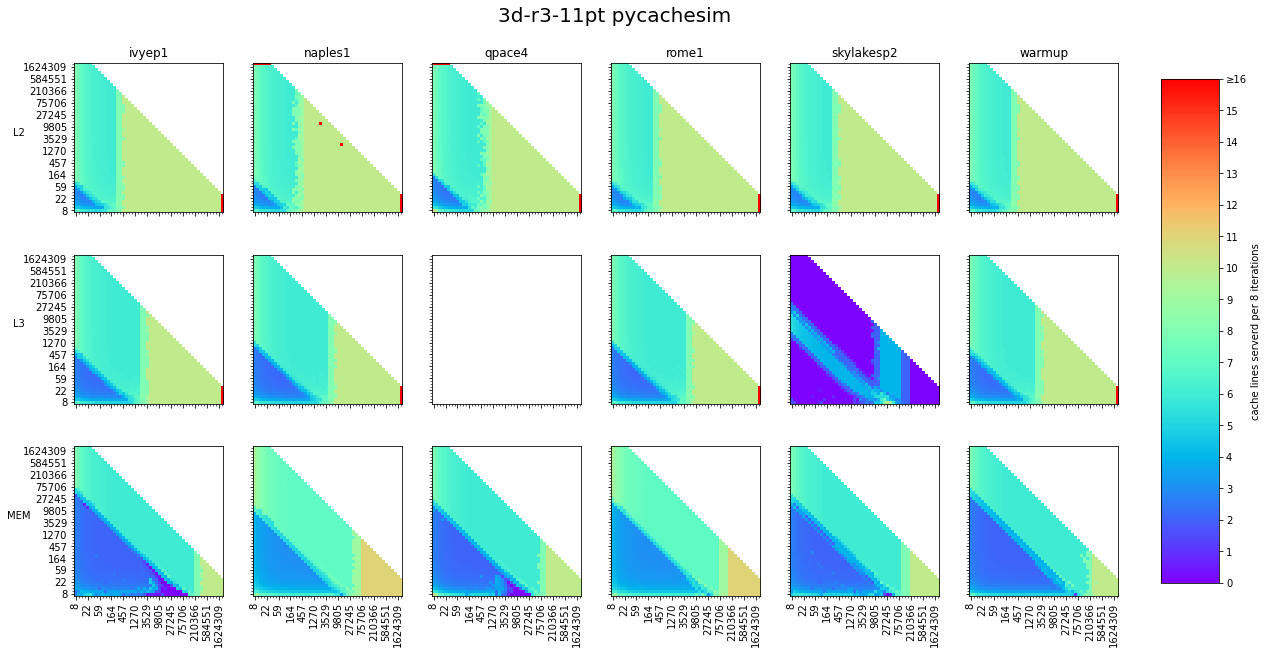

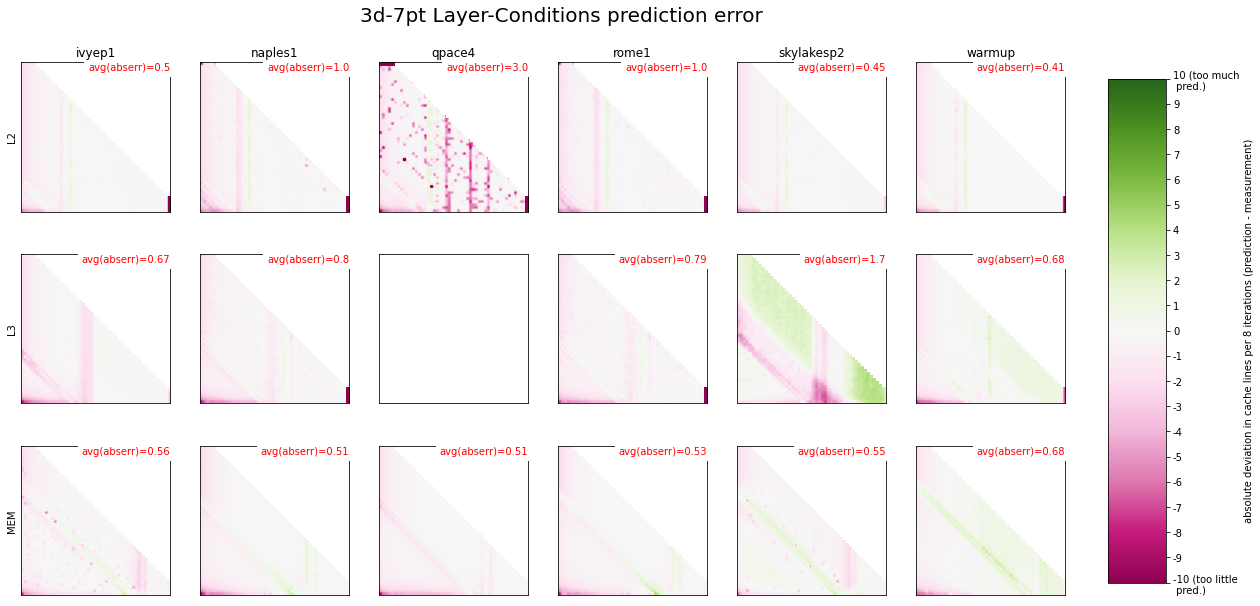

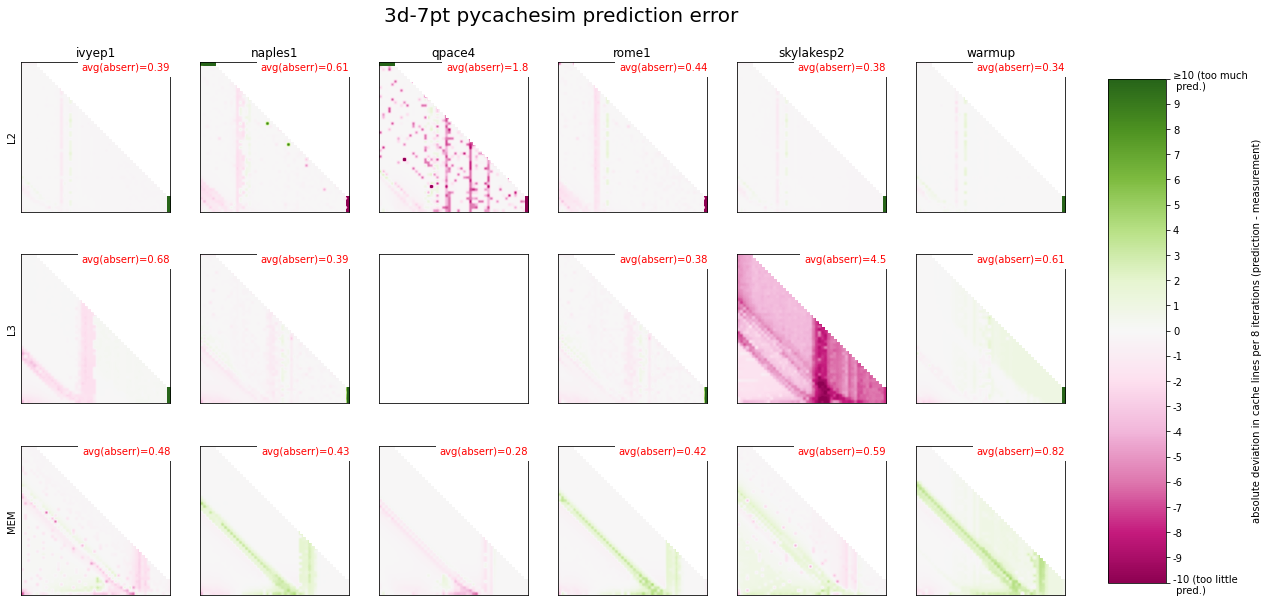

In [20]:
fas = {}
for source in ['measured', 'layer-conditions', 'pycachesim']:
    fas[source] = plot2d('3d-r3-11pt', source, vmin=0, vmax=16)

plot2derr(fas['measured'][1], fas['layer-conditions'][1], "3d-7pt Layer-Conditions prediction error", v=10)
plot2derr(fas['measured'][1], fas['pycachesim'][1], "3d-7pt pycachesim prediction error", v=10)